<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [9.0 Stochastic Projection and Collocation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.00-Stochastic-Projection-and-Collocation.html) | [Contents](toc.html) | [9.2 Uniform Random Variables: Legendre Polynomials](https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.02-Uniform-Random-Variables-Legendre-Polynomials-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/09.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 9.1 Hermite Expansion for Normally Distributed Parameters

Created by Xian Gao (xgao1@nd.edu)

These examples and codes were adapted from:
* McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers*, *Chapter 7 : Sampling-Based Uncertainty Quantification Monte Carlo and Beyond*, Springer, https://link.springer.com/chapter/10.1007%2F978-3-319-99525-0_7
* http://www.cfm.brown.edu/people/dobrush/am34/Mathematica/ch5/hermite.html

In [1]:
## import all needed Python libraries here
import numpy as np
from scipy.special import eval_hermitenorm,eval_hermite
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(250)

## 9.1.1 Hermite Expansion (physicist version)

The Hermite polynomials $H_{n}(x)$ are a set of orthogonal polynomials. Given a function of interests (i.e. QoI), $g(x)$, a Hermite expansion can be used to approximate this.
$$g(x) = \sum_{n = 0}^{\infty} c_{n} H_{n}(x)$$
where the expansion coefficients $c_n$ can be calculated as follows:
$$c_{n} = \frac{<g(x),H_{n}(x)>}{2^{n}n!\sqrt{\pi}} = \frac{1}{2^{n}n!\sqrt{\pi}}\int_{-\infty}^{\infty} g(x)H_{n}(x) e^{-x^2}dx $$.


## Gauss-Hermite Quadrature
Gauss-Hermite quadrature is often used to approximate the integrals with weight function $e^{-x^2}$:
$$\int_{-\infty}^{\infty} f(x) e^{-x^2}dx \approx \sum_{i = 1}^{n} w_i f(x_i)$$
Given the number of quadrature points $n$, quadrature points $x_i$ are the roots of Hermite polynomial (physicists' version) and the weights can be calculated as follows:
$$w_i = \frac{2^{n-1}n!\sqrt{\pi}}{n^2H_{n-1}^{2}(x_i)}$$

This can be naturally used to approximate the Hermite expansion coefficients $c_{n}$:
$$c_{n} = \frac{1}{2^{n}n!\sqrt{\pi}}\int_{-\infty}^{\infty} g(x)H_{n}(x) e^{-x^2}dx \approx \frac{1}{2^{n}n!\sqrt{\pi}}\sum_{i = 1}^{n} w_i g(x_i)H_{n}(x_i)$$


In [2]:
# function to calcualte the hermite expansion coefficient
def calc_hermite_coefficient1(aPoints, aWeights,f,mu=0.0,sigma = 1.0,coefIndex = 0):
    
    '''
    A function to calculate the hermite expansion coefficients.
    Inputs:
        1. aPoints: an array of quadrature points from Gauss-Hermite quadrature rule. (numpy array)
        2. aWeights: an array of quadrature weights from Gauss-Hermite quadrature rule. (numpy array)
        3. f: QoI. (python function)
        4. mu: mean of the Gaussian distribution (float)
        5. sigma: standard deviation of the Gaussian distribution (float)
        6. coefIndex: expansion coefficient index (int)
    Output:
        1. c_n
    '''
    
    # calculate the inner product using Eqn 9.14
    inner_product = sum(aWeights[i] \
                     * f(aPoints[i][0] * sigma + mu)\
                     * eval_hermite(coefIndex, aPoints[i][0])
                      for i in range(aPoints.shape[0]))
    
    return inner_product/(np.sqrt(np.pi) * 2**coefIndex * np.math.factorial(coefIndex))

In [3]:
# use hermite expansion to approximate given coefficient
def hermite_expand(x,expansion_coef):
    '''
    A function to evaluate the value of QoI using Hermite expansion.
    
    Inputs:
        1. x: point that needs to be evaluate
        2. expansion_coef: an array of quadrature weights from Gauss-Hermite quadrature rule. (numpy array)
    Output:
        1. Value of QoI at point x
    '''
    
    accumulate = 0
    for idx, coef in enumerate(expansion_coef):
        accumulate += coef * eval_hermite(idx,x)
    return accumulate

In [4]:
# declare number of dimension and number of quadrature points
iDim = 1
iLevel = 12

# get the quadrature points and weights
aPoints, aWeights = np.polynomial.hermite.hermgauss(iLevel + 1)
aPoints = aPoints.reshape(-1,1)

# declare the mean and variance of the normal distribution
mu = 0.5
var = 4

# specifiy number of samples
numSamples = 10000

# generate samples from standard Gaussian space
sample_standard = np.random.normal(0,1,size = numSamples)

# convert samples
samples = sample_standard * var**0.5 + mu


## 9.1.2 Distribution of $\cos(x)$
Given $x \sim \mathcal{N}(0.5,4)$, what is the distribution of $\cos(x)$?

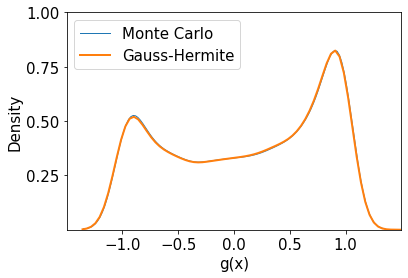

In [5]:
# functions we want to approximate
def f(x):
    return np.cos(x)


# declare number of terms needed
numTerms = 10

# calculate the expansion coefficient
expansion_coef1 = [calc_hermite_coefficient1(aPoints,\
                                             aWeights,\
                                             f = f, \
                                             mu = mu,\
                                             sigma = var**0.5,\
                                             coefIndex = i) for i in range(numTerms)]

# use hermite expansion to calculate QoI
approx = [hermite_expand(x,expansion_coef1) for x in sample_standard]

# plot the density
sns.distplot(f(samples), hist = False, kde = True,
                 kde_kws = {'linewidth': 1},label = 'Monte Carlo')
sns.distplot(approx, hist = False, kde = True,
                  kde_kws = {'linewidth': 2},label = 'Gauss-Hermite')
plt.xlim(-1.5,1.5)
plt.xticks([-1,-0.5,0,0.5,1],fontsize = 15)
plt.yticks([0.25,0.5,0.75,1],fontsize = 15)
plt.legend(fontsize = 15)
plt.xlabel('g(x)',fontsize = 15)
plt.ylabel('Density',fontsize = 15)
plt.show()

## 9.1.3 Distribution of $x\cos(x)$
Given $x \sim \mathcal{N}(0.5,4)$, what is the distribution of $x\cos(x)$?

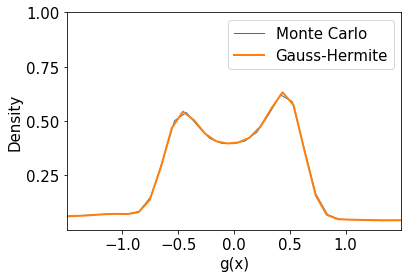

In [6]:
# functions we want to approximate
def g(x):
    return np.cos(x)*x

# declare number of terms needed
numTerms = 12

# calculate the expansion coefficient
expansion_coef1 = [calc_hermite_coefficient1(aPoints,\
                                             aWeights,\
                                             f = g, \
                                             mu = mu,\
                                             sigma = var**0.5,\
                                             coefIndex = i) for i in range(numTerms)]

# use hermite expansion to calculate QoI
approx = [hermite_expand(x,expansion_coef1) for x in sample_standard]

# plot the density
sns.distplot(g(samples), hist = False, kde = True,
                 kde_kws = {'linewidth': 1},label = 'Monte Carlo')
sns.distplot(approx, hist = False, kde = True,
                  kde_kws = {'linewidth': 2},label = 'Gauss-Hermite')
plt.xlim(-1.5,1.5)
plt.xticks([-1,-0.5,0,0.5,1],fontsize = 15)
plt.yticks([0.25,0.5,0.75,1],fontsize = 15)
plt.legend(fontsize = 15)
plt.xlabel('g(x)',fontsize = 15)
plt.ylabel('Density',fontsize = 15)
plt.show()

<!--NAVIGATION-->
< [9.0 Stochastic Projection and Collocation](https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.00-Stochastic-Projection-and-Collocation.html) | [Contents](toc.html) | [9.2 Uniform Random Variables: Legendre Polynomials](https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.02-Uniform-Random-Variables-Legendre-Polynomials-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/09.01-Contributed-Example.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/09.01-Contributed-Example.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>